# Method 9 - Best Ideas DGTW Timing

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)
dgtw_cont = dgtw_cont[dgtw_cont != 0]

rf = bi.get_risk_free_rate()
monthly_return = dgtw_cont.loc['1999-07-01':]
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

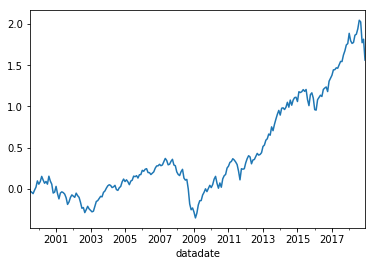

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.096482
2000-12-31   -0.124411
2001-12-31   -0.034936
2002-12-31   -0.182811
2003-12-31    0.332154
2004-12-31    0.109499
2005-12-31    0.048668
2006-12-31    0.090352
2007-12-31    0.000880
2008-12-31   -0.400018
2009-12-31    0.357876
2010-12-31    0.200472
2011-12-31   -0.006805
2012-12-31    0.156705
2013-12-31    0.356512
2014-12-31    0.081645
2015-12-31   -0.004516
2016-12-31    0.114903
2017-12-31    0.178825
2018-12-31   -0.072381
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2183.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.03e-181
Time:                        20:28:42   Log-Likelihood:                 830.23
No. Observations:                 234   AIC:                            -1650.
Df Residuals:                     229   BIC:                            -1633.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      1.580      0.116      -0.000       0.002
mktrf          0.9572      0.013     72.900      0.000       0.931       0.983
me             0.1040      0.015      6.807      0.000       0.074       0.134
ia             0.0220      0.023      0.948      0.344      -0.024       0.068
roe           -0.0118      0.020     -0.594      0.553      -0.051       0.027
==============================================================================
Omnibus:                       63.034   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              594.316
Skew:                           0.718   Prob(JB):                    8.83e-130
Kurtosis:                      10.674   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2935.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.09e-195
Time:                        20:28:42   Log-Likelihood:                 830.23
No. Observations:                 234   AIC:                            -1650.
Df Residuals:                     229   BIC:                            -1633.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.418      0.156      -0.000       0.002
mktrf          0.9572      0.021     44.970      0.000       0.915       0.999
me             0.1040      0.054      1.920      0.055      -0.002       0.210
ia             0.0220      0.044      0.504      0.614      -0.064       0.108
roe           -0.0118      0.042     -0.282      0.778      -0.094       0.070
==============================================================================
Omnibus:                       63.034   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              594.316
Skew:                           0.718   Prob(JB):                    8.83e-130
Kurtosis:                      10.674   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     3380.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.61e-202
Time:                        20:28:42   Log-Likelihood:                 830.23
No. Observations:                 234   AIC:                            -1650.
Df Residuals:                     229   BIC:                            -1633.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.389      0.165      -0.000       0.002
mktrf          0.9572      0.017     55.666      0.000       0.923       0.991
me             0.1040      0.058      1.778      0.075      -0.011       0.219
ia             0.0220      0.036      0.605      0.545      -0.049       0.093
roe           -0.0118      0.037     -0.323      0.747      -0.083       0.060
==============================================================================
Omnibus:                       63.034   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              594.316
Skew:                           0.718   Prob(JB):                    8.83e-130
Kurtosis:                      10.674   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1762.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.81e-180
Time:                        20:28:42   Log-Likelihood:                 831.73
No. Observations:                 234   AIC:                            -1651.
Df Residuals:                     228   BIC:                            -1631.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.922      0.357      -0.001       0.001
mktrf          0.9622      0.013     73.448      0.000       0.936       0.988
smb            0.1525      0.017      8.823      0.000       0.118       0.187
hml            0.0727      0.020      3.565      0.000       0.033       0.113
rmw            0.0385      0.023      1.672      0.096      -0.007       0.084
cma           -0.0918      0.029     -3.133      0.002      -0.149      -0.034
==============================================================================
Omnibus:                       56.800   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              499.726
Skew:                           0.624   Prob(JB):                    3.06e-109
Kurtosis:                      10.050   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1860.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.40e-182
Time:                        20:28:43   Log-Likelihood:                 831.73
No. Observations:                 234   AIC:                            -1651.
Df Residuals:                     228   BIC:                            -1631.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.824      0.410      -0.001       0.002
mktrf          0.9622      0.018     52.415      0.000       0.926       0.998
smb            0.1525      0.043      3.510      0.000       0.067       0.238
hml            0.0727      0.042      1.733      0.083      -0.010       0.155
rmw            0.0385      0.027      1.405      0.160      -0.015       0.092
cma           -0.0918      0.045     -2.051      0.040      -0.179      -0.004
==============================================================================
Omnibus:                       56.800   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              499.726
Skew:                           0.624   Prob(JB):                    3.06e-109
Kurtosis:                      10.050   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2656.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.42e-200
Time:                        20:28:43   Log-Likelihood:                 831.73
No. Observations:                 234   AIC:                            -1651.
Df Residuals:                     228   BIC:                            -1631.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.804      0.422      -0.001       0.002
mktrf          0.9622      0.019     51.967      0.000       0.926       0.999
smb            0.1525      0.044      3.465      0.001       0.066       0.239
hml            0.0727      0.040      1.818      0.069      -0.006       0.151
rmw            0.0385      0.025      1.562      0.118      -0.010       0.087
cma           -0.0918      0.037     -2.495      0.013      -0.164      -0.020
==============================================================================
Omnibus:                       56.800   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              499.726
Skew:                           0.624   Prob(JB):                    3.06e-109
Kurtosis:                      10.050   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2200.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.13e-181
Time:                        20:28:43   Log-Likelihood:                 831.11
No. Observations:                 234   AIC:                            -1652.
Df Residuals:                     229   BIC:                            -1635.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      1.673      0.096      -0.000       0.002
mktrf          0.9414      0.012     78.164      0.000       0.918       0.965
smb            0.1346      0.015      8.954      0.000       0.105       0.164
hml            0.0610      0.015      4.082      0.000       0.032       0.090
umd           -0.0459      0.010     -4.683      0.000      -0.065      -0.027
==============================================================================
Omnibus:                       35.020   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              214.146
Skew:                           0.289   Prob(JB):                     3.15e-47
Kurtosis:                       7.651   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2691.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.55e-191
Time:                        20:28:43   Log-Likelihood:                 831.11
No. Observations:                 234   AIC:                            -1652.
Df Residuals:                     229   BIC:                            -1635.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.440      0.150      -0.000       0.002
mktrf          0.9414      0.017     56.299      0.000       0.909       0.974
smb            0.1346      0.042      3.178      0.001       0.052       0.218
hml            0.0610      0.024      2.521      0.012       0.014       0.108
umd           -0.0459      0.021     -2.172      0.030      -0.087      -0.004
==============================================================================
Omnibus:                       35.020   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              214.146
Skew:                           0.289   Prob(JB):                     3.15e-47
Kurtosis:                       7.651   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     3194.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.57e-199
Time:                        20:28:43   Log-Likelihood:                 831.11
No. Observations:                 234   AIC:                            -1652.
Df Residuals:                     229   BIC:                            -1635.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.380      0.168      -0.000       0.002
mktrf          0.9414      0.017     56.901      0.000       0.909       0.974
smb            0.1346      0.041      3.282      0.001       0.054       0.215
hml            0.0610      0.025      2.449      0.014       0.012       0.110
umd           -0.0459      0.021     -2.213      0.027      -0.087      -0.005
==============================================================================
Omnibus:                       35.020   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              214.146
Skew:                           0.289   Prob(JB):                     3.15e-47
Kurtosis:                       7.651   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     857.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.35e-84
Time:                        20:28:43   Log-Likelihood:                 399.15
No. Observations:                 120   AIC:                            -788.3
Df Residuals:                     115   BIC:                            -774.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.433      0.155      -0.000       0.003
mktrf          0.9550      0.023     41.722      0.000       0.910       1.000
me             0.0637      0.023      2.819      0.006       0.019       0.109
ia             0.0290      0.035      0.820      0.414      -0.041       0.099
roe           -0.0213      0.031     -0.679      0.498      -0.083       0.041
==============================================================================
Omnibus:                       28.427   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.711
Skew:                           0.781   Prob(JB):                     2.01e-20
Kurtosis:                       6.963   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     1322.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.26e-95
Time:                        20:28:43   Log-Likelihood:                 399.15
No. Observations:                 120   AIC:                            -788.3
Df Residuals:                     115   BIC:                            -774.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.180      0.238      -0.001       0.003
mktrf          0.9550      0.030     32.004      0.000       0.897       1.013
me             0.0637      0.059      1.086      0.277      -0.051       0.179
ia             0.0290      0.054      0.538      0.590      -0.077       0.135
roe           -0.0213      0.057     -0.374      0.708      -0.133       0.090
==============================================================================
Omnibus:                       28.427   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.711
Skew:                           0.781   Prob(JB):                     2.01e-20
Kurtosis:                       6.963   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     1950.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.24e-104
Time:                        20:28:43   Log-Likelihood:                 399.15
No. Observations:                 120   AIC:                            -788.3
Df Residuals:                     115   BIC:                            -774.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.056      0.291      -0.001       0.003
mktrf          0.9550      0.022     44.065      0.000       0.913       0.997
me             0.0637      0.064      0.989      0.323      -0.063       0.190
ia             0.0290      0.046      0.633      0.527      -0.061       0.119
roe           -0.0213      0.049     -0.436      0.663      -0.117       0.074
==============================================================================
Omnibus:                       28.427   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.711
Skew:                           0.781   Prob(JB):                     2.01e-20
Kurtosis:                       6.963   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     635.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.81e-81
Time:                        20:28:43   Log-Likelihood:                 395.18
No. Observations:                 120   AIC:                            -778.4
Df Residuals:                     114   BIC:                            -761.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.261      0.210      -0.001       0.003
mktrf          0.9912      0.025     39.558      0.000       0.942       1.041
smb            0.1352      0.028      4.765      0.000       0.079       0.191
hml            0.0493      0.035      1.417      0.159      -0.020       0.118
rmw            0.0703      0.041      1.714      0.089      -0.011       0.152
cma           -0.0705      0.045     -1.570      0.119      -0.160       0.018
==============================================================================
Omnibus:                       17.934   Durbin-Watson:                   1.701
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.061
Skew:                           0.419   Prob(JB):                     1.82e-12
Kurtosis:                       6.180   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     799.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.54e-87
Time:                        20:28:43   Log-Likelihood:                 395.18
No. Observations:                 120   AIC:                            -778.4
Df Residuals:                     114   BIC:                            -761.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.128      0.259      -0.001       0.003
mktrf          0.9912      0.034     29.383      0.000       0.925       1.057
smb            0.1352      0.060      2.272      0.023       0.019       0.252
hml            0.0493      0.063      0.780      0.435      -0.074       0.173
rmw            0.0703      0.055      1.280      0.201      -0.037       0.178
cma           -0.0705      0.066     -1.062      0.288      -0.201       0.060
==============================================================================
Omnibus:                       17.934   Durbin-Watson:                   1.701
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.061
Skew:                           0.419   Prob(JB):                     1.82e-12
Kurtosis:                       6.180   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     1201.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.41e-97
Time:                        20:28:43   Log-Likelihood:                 395.18
No. Observations:                 120   AIC:                            -778.4
Df Residuals:                     114   BIC:                            -761.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.075      0.282      -0.001       0.003
mktrf          0.9912      0.036     27.768      0.000       0.921       1.061
smb            0.1352      0.060      2.256      0.024       0.018       0.253
hml            0.0493      0.062      0.801      0.423      -0.071       0.170
rmw            0.0703      0.057      1.240      0.215      -0.041       0.181
cma           -0.0705      0.056     -1.270      0.204      -0.179       0.038
==============================================================================
Omnibus:                       17.934   Durbin-Watson:                   1.701
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.061
Skew:                           0.419   Prob(JB):                     1.82e-12
Kurtosis:                       6.180   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     818.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.78e-83
Time:                        20:28:43   Log-Likelihood:                 396.45
No. Observations:                 120   AIC:                            -782.9
Df Residuals:                     115   BIC:                            -769.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.963      0.052    -1.5e-05       0.003
mktrf          0.9452      0.021     45.833      0.000       0.904       0.986
smb            0.1119      0.023      4.765      0.000       0.065       0.158
hml            0.0630      0.024      2.679      0.008       0.016       0.110
umd           -0.0512      0.015     -3.528      0.001      -0.080      -0.022
==============================================================================
Omnibus:                        7.452   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.024   Jarque-Bera (JB):               14.128
Skew:                           0.023   Prob(JB):                     0.000855
Kurtosis:                       4.680   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1132.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.52e-91
Time:                        20:28:43   Log-Likelihood:                 396.45
No. Observations:                 120   AIC:                            -782.9
Df Residuals:                     115   BIC:                            -769.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.898      0.058   -5.49e-05       0.003
mktrf          0.9452      0.026     36.488      0.000       0.894       0.996
smb            0.1119      0.047      2.386      0.017       0.020       0.204
hml            0.0630      0.030      2.091      0.037       0.004       0.122
umd           -0.0512      0.024     -2.151      0.031      -0.098      -0.005
==============================================================================
Omnibus:                        7.452   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.024   Jarque-Bera (JB):               14.128
Skew:                           0.023   Prob(JB):                     0.000855
Kurtosis:                       4.680   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1283.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.24e-94
Time:                        20:28:43   Log-Likelihood:                 396.45
No. Observations:                 120   AIC:                            -782.9
Df Residuals:                     115   BIC:                            -769.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.818      0.069      -0.000       0.003
mktrf          0.9452      0.026     36.065      0.000       0.894       0.997
smb            0.1119      0.045      2.505      0.012       0.024       0.199
hml            0.0630      0.031      2.040      0.041       0.002       0.124
umd           -0.0512      0.022     -2.311      0.021      -0.095      -0.008
==============================================================================
Omnibus:                        7.452   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.024   Jarque-Bera (JB):               14.128
Skew:                           0.023   Prob(JB):                     0.000855
Kurtosis:                       4.680   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     3541.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.28e-114
Time:                        20:28:43   Log-Likelihood:                 491.20
No. Observations:                 114   AIC:                            -972.4
Df Residuals:                     109   BIC:                            -958.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      2.352      0.020       0.000       0.001
mktrf          0.9333      0.010     95.371      0.000       0.914       0.953
me             0.2235      0.015     14.795      0.000       0.194       0.253
ia            -0.0216      0.021     -1.031      0.305      -0.063       0.020
roe           -0.0157      0.018     -0.852      0.396      -0.052       0.021
==============================================================================
Omnibus:                        0.757   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.685   Jarque-Bera (JB):                0.361
Skew:                          -0.074   Prob(JB):                        0.835
Kurtosis:                       3.233   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     3382.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.75e-113
Time:                        20:28:43   Log-Likelihood:                 491.20
No. Observations:                 114   AIC:                            -972.4
Df Residuals:                     109   BIC:                            -958.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      2.446      0.014       0.000       0.001
mktrf          0.9333      0.011     84.154      0.000       0.912       0.955
me             0.2235      0.017     13.411      0.000       0.191       0.256
ia            -0.0216      0.025     -0.858      0.391      -0.071       0.028
roe           -0.0157      0.013     -1.218      0.223      -0.041       0.010
==============================================================================
Omnibus:                        0.757   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.685   Jarque-Bera (JB):                0.361
Skew:                          -0.074   Prob(JB):                        0.835
Kurtosis:                       3.233   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     4062.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.37e-117
Time:                        20:28:43   Log-Likelihood:                 491.20
No. Observations:                 114   AIC:                            -972.4
Df Residuals:                     109   BIC:                            -958.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      2.855      0.004       0.000       0.001
mktrf          0.9333      0.011     84.031      0.000       0.912       0.955
me             0.2235      0.016     14.055      0.000       0.192       0.255
ia            -0.0216      0.025     -0.874      0.382      -0.070       0.027
roe           -0.0157      0.012     -1.287      0.198      -0.040       0.008
==============================================================================
Omnibus:                        0.757   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.685   Jarque-Bera (JB):                0.361
Skew:                          -0.074   Prob(JB):                        0.835
Kurtosis:                       3.233   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     4574.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.02e-124
Time:                        20:28:43   Log-Likelihood:                 518.86
No. Observations:                 114   AIC:                            -1026.
Df Residuals:                     108   BIC:                            -1009.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.422      0.674      -0.000       0.001
mktrf          0.9309      0.007    126.555      0.000       0.916       0.945
smb            0.1996      0.012     16.715      0.000       0.176       0.223
hml            0.0433      0.015      2.841      0.005       0.013       0.073
rmw           -0.0575      0.019     -3.085      0.003      -0.094      -0.021
cma           -0.0823      0.024     -3.479      0.001      -0.129      -0.035
==============================================================================
Omnibus:                        1.582   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.453   Jarque-Bera (JB):                1.098
Skew:                           0.203   Prob(JB):                        0.577
Kurtosis:                       3.257   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     2469.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.39e-109
Time:                        20:28:43   Log-Likelihood:                 518.86
No. Observations:                 114   AIC:                            -1026.
Df Residuals:                     108   BIC:                            -1009.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.369      0.712      -0.000       0.001
mktrf          0.9309      0.010     92.659      0.000       0.911       0.951
smb            0.1996      0.011     18.263      0.000       0.178       0.221
hml            0.0433      0.010      4.360      0.000       0.024       0.063
rmw           -0.0575      0.015     -3.750      0.000      -0.088      -0.027
cma           -0.0823      0.016     -5.089      0.000      -0.114      -0.051
==============================================================================
Omnibus:                        1.582   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.453   Jarque-Bera (JB):                1.098
Skew:                           0.203   Prob(JB):                        0.577
Kurtosis:                       3.257   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     3027.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.52e-114
Time:                        20:28:43   Log-Likelihood:                 518.86
No. Observations:                 114   AIC:                            -1026.
Df Residuals:                     108   BIC:                            -1009.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.324      0.746      -0.001       0.001
mktrf          0.9309      0.010     92.063      0.000       0.911       0.951
smb            0.1996      0.011     17.965      0.000       0.178       0.221
hml            0.0433      0.009      4.651      0.000       0.025       0.062
rmw           -0.0575      0.016     -3.631      0.000      -0.089      -0.026
cma           -0.0823      0.013     -6.331      0.000      -0.108      -0.057
==============================================================================
Omnibus:                        1.582   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.453   Jarque-Bera (JB):                1.098
Skew:                           0.203   Prob(JB):                        0.577
Kurtosis:                       3.257   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     4691.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.60e-121
Time:                        20:28:43   Log-Likelihood:                 507.11
No. Observations:                 114   AIC:                            -1004.
Df Residuals:                     109   BIC:                            -990.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.269e-05      0.000     -0.322      0.748      -0.001       0.000
mktrf          0.9368      0.008    116.161      0.000       0.921       0.953
smb            0.2142      0.013     17.036      0.000       0.189       0.239
hml            0.0298      0.013      2.302      0.023       0.004       0.055
umd           -0.0111      0.010     -1.140      0.257      -0.030       0.008
==============================================================================
Omnibus:                        2.760   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.252   Jarque-Bera (JB):                2.192
Skew:                           0.252   Prob(JB):                        0.334
Kurtosis:                       3.456   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     2605.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.59e-107
Time:                        20:28:43   Log-Likelihood:                 507.11
No. Observations:                 114   AIC:                            -1004.
Df Residuals:                     109   BIC:                            -990.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.269e-05      0.000     -0.294      0.769      -0.001       0.001
mktrf          0.9368      0.011     86.878      0.000       0.916       0.958
smb            0.2142      0.012     17.888      0.000       0.191       0.238
hml            0.0298      0.013      2.325      0.020       0.005       0.055
umd           -0.0111      0.014     -0.789      0.430      -0.039       0.017
==============================================================================
Omnibus:                        2.760   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.252   Jarque-Bera (JB):                2.192
Skew:                           0.252   Prob(JB):                        0.334
Kurtosis:                       3.456   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     3379.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.89e-113
Time:                        20:28:43   Log-Likelihood:                 507.11
No. Observations:                 114   AIC:                            -1004.
Df Residuals:                     109   BIC:                            -990.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.269e-05      0.000     -0.274      0.784      -0.001       0.001
mktrf          0.9368      0.011     87.224      0.000       0.916       0.958
smb            0.2142      0.011     19.412      0.000       0.193       0.236
hml            0.0298      0.013      2.347      0.019       0.005       0.055
umd           -0.0111      0.015     -0.754      0.451      -0.040       0.018
==============================================================================
Omnibus:                        2.760   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.252   Jarque-Bera (JB):                2.192
Skew:                           0.252   Prob(JB):                        0.334
Kurtosis:                       3.456   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""